Authentication with EllipticManifold
===

<div class="alert alert-block alert-info"> 
Author: Nathan A. Mahynski

Date: 2023/08/23

Description: Illustrate modeling with the EllipticManifold model.
</div>

In <a href="https://doi.org/10.1016/S0169-7439(02)00107-7">projection methods<a> a dimensionality reduction is first performed to compress the data into a lower dimensional space; authentication can be performed by enveloping the projected points in an elliptical boundary.  The cutoff for this boundary 

In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !git clone https://github.com/mahynski/pychemauth.git --depth 1
    !cd pychemauth; pip3 install .; cd ..

try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib notebook

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sklearn.decomposition
import sklearn.manifold

from pychemauth.manifold.elliptic import EllipticManifold

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-26-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

numpy     : 1.24.4
json      : 2.0.9
matplotlib: 3.7.2
watermark : 2.4.3
pychemauth: 0.0.0b3
sklearn   : 1.3.0



<h3>Load the Data</h3>

In [4]:
from sklearn.datasets import load_iris as load_data
X, y = load_data(return_X_y=True, as_frame=True)

In [5]:
# Let's turn the indices into names
names = dict(zip(np.arange(3), ['setosa', 'versicolor', 'virginica'])) 
y = y.apply(lambda x: names[x])

In [6]:
X.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values, # Let's try to predict the salary based on the other numerical features.
    shuffle=True,
    random_state=42,
    test_size=0.2,
    stratify=y # It is usually important to balance the test and train set so they have the same fraction of classes
)

In [15]:
# Again, if more than 1 class is passed an exception is thrown
m = EllipticManifold(
    alpha=0.05, 
    dr_model=sklearn.decomposition.PCA, 
    kwargs={'n_components':2}
)
_ = m.fit(X_train)

<IPython.core.display.Javascript object>


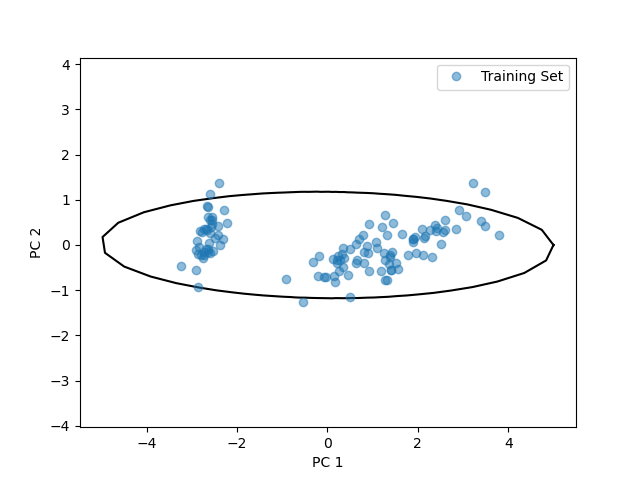

In [16]:
_ = m.visualize([X_train], ['Training Set'])

Kernel PCA Example
---

See [scikit-learn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html?highlight=kernel%20pca#sklearn.decomposition.KernelPCA) for details on hyperparameters.

In [ ]:
model = sklearn.decomposition.KernelPCA
kwargs = {"n_components":1, "kernel":"linear"}

m = EllipticManifold(0.05, model, kwargs)
_ = m.fit(X_train)

_ = m.visualize([X_train_scaled, X_test_scaled, X_1_scaled, X_2_scaled], ["Training Set", "Test Set", "Class 1", "Class 2"])

In [ ]:
m.score(X_test_scaled, [1]*len(X_test_scaled))

In [ ]:
m.score(X_1_scaled, [0]*len(X_1_scaled)) # 1D is not enough to distinguish class 0 from 1

In [ ]:
# Try a 2D model instead
kwargs = {"n_components":2, "kernel":"linear"}

m = EllipticManifold(0.05, model, kwargs)

In [ ]:
_ = m.fit(X_train_scaled)

In [ ]:
_ = m.visualize([X_train_scaled, X_test_scaled, X_1_scaled, X_2_scaled], ["Training Set", "Test Set", "Class 1", "Class 2"])

In [ ]:
m.predict(X_test_scaled, y_test) # 1 = inliner, 0 = outlier

In [ ]:
m.score(X_test_scaled, [1]*len(X_test_scaled)) # Score the test set (all same class as training)

In [ ]:
m.score(X_1_scaled, [0]*len(X_1_scaled)) # Score a different class (different from training)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,6))
ax = axes.flatten()

idx = 0
for dims in [1, 2]:
    scores = []
    for degree in [1, 3, 5]:
        model = sklearn.decomposition.KernelPCA
        kwargs = {"n_components":dims, 
                  "kernel":"poly", 
                  "degree":degree 
                 }
        m = EllipticManifold(0.05, model, kwargs)
        _ = m.fit(X_train_scaled)
        train_score = m.score(X_train_scaled, [1]*len(X_train_scaled))
        test_score = m.score(X_test_scaled, [1]*len(X_test_scaled))
        x1_score = m.score(X_1_scaled, [0]*len(X_1_scaled))
        x2_score = m.score(X_2_scaled, [0]*len(X_2_scaled))
        scores.append([train_score, test_score, x1_score, x2_score])
        
        ax_ = m.visualize([X_train_scaled, X_test_scaled, X_1_scaled, X_2_scaled], ["Training Set", "Test Set", "Class 1", "Class 2"], ax[idx])
        ax_.set_title('Degree = {}, Test Score = {}\nX_1 Score = {}, X_2 Score = {}'.format(
            '%.3f'%degree, '%.3f'%test_score, '%.3f'%x1_score, '%.3f'%x2_score))
        idx += 1
    scores = np.array(scores)
    ax[idx].plot([1, 3, 5], scores[:, 0], '-o', alpha=0.5, label='Train')
    ax[idx].plot([1, 3, 5], scores[:, 1], '-s', alpha=0.5, label='Test')
    ax[idx].plot([1, 3, 5], scores[:, 2], '-*', alpha=0.5, label='X_1')
    ax[idx].plot([1, 3, 5], scores[:, 3], '-^', alpha=0.5, label='X_2')
    ax[idx].set_xlabel('Degree')
    ax[idx].set_ylabel('Score')
    ax[idx].legend(loc='best')
    idx += 1

plt.tight_layout()

Isomap Example
---

See [scikit-learn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html?highlight=isomap#sklearn.manifold.Isomap) for details on hyperparameters.

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,6))
ax = axes.flatten()

idx = 0
for dims in [1, 2]:
    scores = []
    for nebrs in [5, 10, 20]:
        model = sklearn.manifold.Isomap
        kwargs = {"n_neighbors":nebrs, 
                  "n_components":dims, 
                  "metric":'minkowski', 
                  "p":2, 
                 }
        m = EllipticManifold(0.05, model, kwargs)
        _ = m.fit(X_train_scaled)
        train_score = m.score(X_train_scaled, [1]*len(X_train_scaled))
        test_score = m.score(X_test_scaled, [1]*len(X_test_scaled))
        x1_score = m.score(X_1_scaled, [0]*len(X_1_scaled))
        x2_score = m.score(X_2_scaled, [0]*len(X_2_scaled))
        scores.append([train_score, test_score, x1_score, x2_score])
        
        ax_ = m.visualize([X_train_scaled, X_test_scaled, X_1_scaled, X_2_scaled], ["Training Set", "Test Set", "Class 1", "Class 2"], ax[idx])
        ax_.set_title('Nebrs = {}, Test Score = {}\nX_1 Score = {}, X_2 Score = {}'.format(
            nebrs, '%.3f'%test_score, '%.3f'%x1_score, '%.3f'%x2_score))
        idx += 1
    scores = np.array(scores)
    ax[idx].plot([5, 15, 30], scores[:, 0], '-o', alpha=0.5, label='Train')
    ax[idx].plot([5, 15, 30], scores[:, 1], '-s', alpha=0.5, label='Test')
    ax[idx].plot([5, 15, 30], scores[:, 2], '-*', alpha=0.5, label='X_1')
    ax[idx].plot([5, 15, 30], scores[:, 3], '-^', alpha=0.5, label='X_2')
    ax[idx].set_xlabel('Nebrs')
    ax[idx].set_ylabel('Score')
    ax[idx].legend(loc='best')
    idx += 1

plt.tight_layout()

LLE Example
---

See [scikit-learn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html?highlight=locally%20linear#sklearn.manifold.LocallyLinearEmbedding) for details on hyperparameters.

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,6))
ax = axes.flatten()

idx = 0
for dims in [1, 2]:
    scores = []
    for nebrs in [5, 15, 30]:
        model = sklearn.manifold.LocallyLinearEmbedding
        kwargs = {"n_neighbors":nebrs, 
                  "n_components":dims,
                 }
        m = EllipticManifold(0.05, model, kwargs)
        _ = m.fit(X_train_scaled)
        train_score = m.score(X_train_scaled, [1]*len(X_train_scaled))
        test_score = m.score(X_test_scaled, [1]*len(X_test_scaled))
        x1_score = m.score(X_1_scaled, [0]*len(X_1_scaled))
        x2_score = m.score(X_2_scaled, [0]*len(X_2_scaled))
        scores.append([train_score, test_score, x1_score, x2_score])
        
        ax_ = m.visualize([X_train_scaled, X_test_scaled, X_1_scaled, X_2_scaled], ["Training Set", "Test Set", "Class 1", "Class 2"], ax[idx])
        ax_.set_title('Nebrs = {}, Test Score = {}\nX_1 Score = {}, X_2 Score = {}'.format(
            nebrs, '%.3f'%test_score, '%.3f'%x1_score, '%.3f'%x2_score))
        idx += 1
    scores = np.array(scores)
    ax[idx].plot([5, 15, 30], scores[:, 0], '-o', alpha=0.5, label='Train')
    ax[idx].plot([5, 15, 30], scores[:, 1], '-s', alpha=0.5, label='Test')
    ax[idx].plot([5, 15, 30], scores[:, 2], '-*', alpha=0.5, label='X_1')
    ax[idx].plot([5, 15, 30], scores[:, 3], '-^', alpha=0.5, label='X_2')
    ax[idx].set_xlabel('Nebrs')
    ax[idx].set_ylabel('Score')
    ax[idx].legend(loc='best')
    idx += 1

plt.tight_layout()

UMAP Example
---

UMAP has a lot of parameters that should be understood before using it.  See the [documentation](https://umap-learn.readthedocs.io/en/latest/parameters.html) for explanation. Briefly, there are 4 that matter the most:
* n_neighbors
* n_components
* metric
* min_dist

**IMPORTANTLY** you should always set random_state to ensure reproducibility between runs since UMAP is stochastic.

In [ ]:
import umap

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,6))
ax = axes.flatten()

idx = 0
for dims in [1, 2]:
    scores = []
    for nebrs in [5, 15, 30]:
        model = umap.UMAP
        kwargs = {"n_neighbors":nebrs, # Less focuses on finer detail, more is "bigger picture"
                  "n_components":dims, # Final dimensionality
                  "random_state":0, # Always set this for reproducibility
                  "metric":"euclidean", # How to compute distance between points in the ambient input space
                  "min_dist":1.0 # Closest points are allowed to come in the embedding (only controls training data, test can end up closer)
                 }
        m = EllipticManifold(0.05, model, kwargs)
        _ = m.fit(X_train_scaled)
        train_score = m.score(X_train_scaled, [1]*len(X_train_scaled))
        test_score = m.score(X_test_scaled, [1]*len(X_test_scaled))
        x1_score = m.score(X_1_scaled, [0]*len(X_1_scaled))
        x2_score = m.score(X_2_scaled, [0]*len(X_2_scaled))
        scores.append([train_score, test_score, x1_score, x2_score])
        
        ax_ = m.visualize([X_train_scaled, X_test_scaled, X_1_scaled, X_2_scaled], ["Training Set", "Test Set", "Class 1", "Class 2"], ax[idx])
        ax_.set_title('Nebrs = {}, Test Score = {}\nX_1 Score = {}, X_2 Score = {}'.format(
            nebrs, '%.3f'%test_score, '%.3f'%x1_score, '%.3f'%x2_score))
        idx += 1
    scores = np.array(scores)
    ax[idx].plot([5, 15, 30], scores[:, 0], '-o', alpha=0.5, label='Train')
    ax[idx].plot([5, 15, 30], scores[:, 1], '-s', alpha=0.5, label='Test')
    ax[idx].plot([5, 15, 30], scores[:, 2], '-*', alpha=0.5, label='X_1')
    ax[idx].plot([5, 15, 30], scores[:, 3], '-^', alpha=0.5, label='X_2')
    ax[idx].set_xlabel('Nebrs')
    ax[idx].set_ylabel('Score')
    ax[idx].legend(loc='best')
    idx += 1

plt.tight_layout()